# Testing Attention Mechanisms

This notebook demonstrates and visualizes the implementation of:
1. DilatedAttention
2. MultiheadDilatedAttention

We'll create some sample inputs and visualize how the attention patterns work.

In [1]:
import os
os.chdir("../")

In [20]:
import torch
import math
import numpy as np
import matplotlib.pyplot as plt
from einops import rearrange, einsum

# Set random seed for reproducibility
torch.manual_seed(42)
np.random.seed(42)

# Set device
device = "cuda" if torch.cuda.is_available() else "cpu"

### Reimplementation of Dilated Attention 

Contrary to the implementation in the `model.py`, here compute attention by hand

In [62]:
import torch.nn as nn
import torch
import xformers.ops as xops
import torch.nn.functional as F

class DilatedAttention(nn.Module):
    """
    Implement dilated, scaled dot product attention with softmax.

    Arguments:
    ---------
        softmax_scale: The temperature to use for the softmax attention.
                       (default: 1/sqrt(d_keys) where d_keys is computed at runtime)
        attention_dropout: The dropout rate to apply to the attention (default: 0.0)
    """

    def __init__(self, segment_lengths, dilation_rates, softmax_scale=None, attention_dropout=0.0, ops=False):
        super().__init__()
        if len(segment_lengths) != len(dilation_rates):
            raise ValueError(
                "segment_lengths and dilation_rates must have the same length")

        self.segment_lengths = segment_lengths
        self.dilation_rates = dilation_rates
        self.softmax_scale = softmax_scale
        self.dropout_p = attention_dropout
        self.ops = ops
        self.op = None

    def forward(self, query, key, value, is_causal=False):
        # Notation:
        #   B - batch size
        #   T - sequence length
        #   H - number of heads
        #   D - embedding dimension
        #   S - segment length
        #   R - dilation rate
        #   G - group size (i.e., number of heads per segment length)
        #
        # Input shape of query, key, value: (B, T, H, D)
        B, _, H, _ = query.shape
        out = torch.zeros_like(query)

        # Divide into groups for each dilation rate and segment length (the two lists have the same size)
        num_groups = len(self.dilation_rates)
        group_sizes = [H // num_groups] * num_groups

        attn_weights_agg = []

        # Groups are not necessarily equal
        for i in range(H % num_groups):
            group_sizes[i] += 1

        for i, (G, R, S) in enumerate(zip(group_sizes, self.dilation_rates, self.segment_lengths)):
            # Split the input sequences into segments of length 'S'
            q = rearrange(query, "B (T S) H D -> B T S H D", S=S)
            k = rearrange(key, "B (T S) H D -> B T S H D", S=S)
            v = rearrange(value, "B (T S) H D -> B T S H D", S=S)
            # Apply dilation and segment offset
            offset = i % R
            hmin = i * G
            hmax = (i + 1) * G
            q = q[:, :, offset::R, hmin:hmax, :]
            k = k[:, :, offset::R, hmin:hmax, :]
            v = v[:, :, offset::R, hmin:hmax, :]
            # Fold all 'T' segments into the batch dimension
            q = rearrange(q, "B T S H D -> (B T) S H D")
            k = rearrange(k, "B T S H D -> (B T) S H D")
            v = rearrange(v, "B T S H D -> (B T) S H D")

            if self.ops:
                # Apply memory-efficient attention
                attn_bias = xops.LowerTriangularMask() if is_causal else None
                x = xops.memory_efficient_attention(
                    query=q, key=k, value=v, op=self.op, attn_bias=attn_bias)
                
            else:
                # Compute attention scores
                attn_logits = einsum(q, k, 'B S1 H D, B S2 H D -> B S1 S2 H')
                if self.softmax_scale is None:
                    softmax_scale = 1.0 / torch.sqrt(torch.tensor(D, dtype=torch.float32))
                else:
                    softmax_scale = self.softmax_scale
                attn_logits = attn_logits * softmax_scale

                

                if is_causal:
                    mask = torch.tril(torch.ones(S//R, S//R)).unsqueeze(0).unsqueeze(-1).expand(*attn_logits.shape).to(attn_logits.device)
                    attn_logits = attn_logits.masked_fill(mask == 0, float('-inf'))


                shape = tuple(attn_logits.shape)
                attn_weights = F.softmax(attn_logits.view(B, -1, G), dim=1).view(*shape) # softmax on both dim (height and width)
                attn_weights_agg.append(rearrange(attn_weights, '(B T) S1 S2 H -> B T S1 S2 H', B=B))
                attn_weights = F.dropout(attn_weights, p=self.dropout_p, training=self.training)
                # Compute attention output
                x = einsum(attn_weights, v, 'B S S2 H, B S H D -> B S H D')

            # Unfold 'T' segments back out of the batch dimension
            x = rearrange(x, "(B T) S H D -> B T S H D", B=B)

             # Normalize attention outputs across the sequence length dimension
            x = x / x.sum(dim=(1, 2), keepdim=True)

            # Gather the attention outputs from each dilation rate / segment length
            out = rearrange(out, "B (T S) H D -> B T S H D", S=S)
            out[:, :, offset::R, hmin:hmax, :] += x
            out = rearrange(out, "B T S H D -> B (T S) H D", S=S)

        # Normalize across all attention outputs by dividing by the number of attention groups
        return out / num_groups, attn_weights_agg


class MultiheadDilatedAttention(nn.Module):
    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # Key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(
            config.n_embd, 3 * config.n_embd, bias=config.bias)
        # Output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # Regularization
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.attention = DilatedAttention(
            segment_lengths = [16, 32, 64, 128],  # 4 segments of length 4
            dilation_rates = [1, 2, 4, 8],   # different dilation rates
            attention_dropout=config.dropout
        )

    def forward(self, x):
        B, T, D = x.size()  # Batch size, sequence length, embedding dimensionality (n_embd)

        # Calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, D // self.n_head)  # (B, T, H, D)
        q = q.view(B, T, self.n_head, D // self.n_head)  # (B, T, H, D)
        v = v.view(B, T, self.n_head, D // self.n_head)  # (B, T, H, D)
        y = self.attention(q, k, v, is_causal=True)[0]
        y = rearrange(y, 'B T H D -> B T (H D)')
        y = self.resid_dropout(self.c_proj(y))
        return y

## 1. Testing DilatedAttention

Let's create a small example to visualize how the dilated attention works with different segment lengths and dilation rates.

In [63]:
# Create sample inputs
B, T, H, D = 1, 128, 16, 32  # batch, seq_len, heads, dim
query = torch.randn(B, T, H, D).to(device)
key = torch.randn(B, T, H, D).to(device)
value = torch.randn(B, T, H, D).to(device)

# Initialize attention with different segment lengths and dilation rates
segment_lengths = [16, 32, 64, 128]  # 4 segments of length 4
dilation_rates = [1, 2, 4, 8]   # different dilation rates
attention = DilatedAttention(segment_lengths, dilation_rates).to(device)

# Forward pass
output, att_agg = attention(query, key, value, is_causal=True)

print(f"Input shape: {query.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 128, 16, 32])
Output shape: torch.Size([1, 128, 16, 32])


### Visualizing Attention Patterns

Let's create a function to visualize the attention patterns for each head and dilation rate.

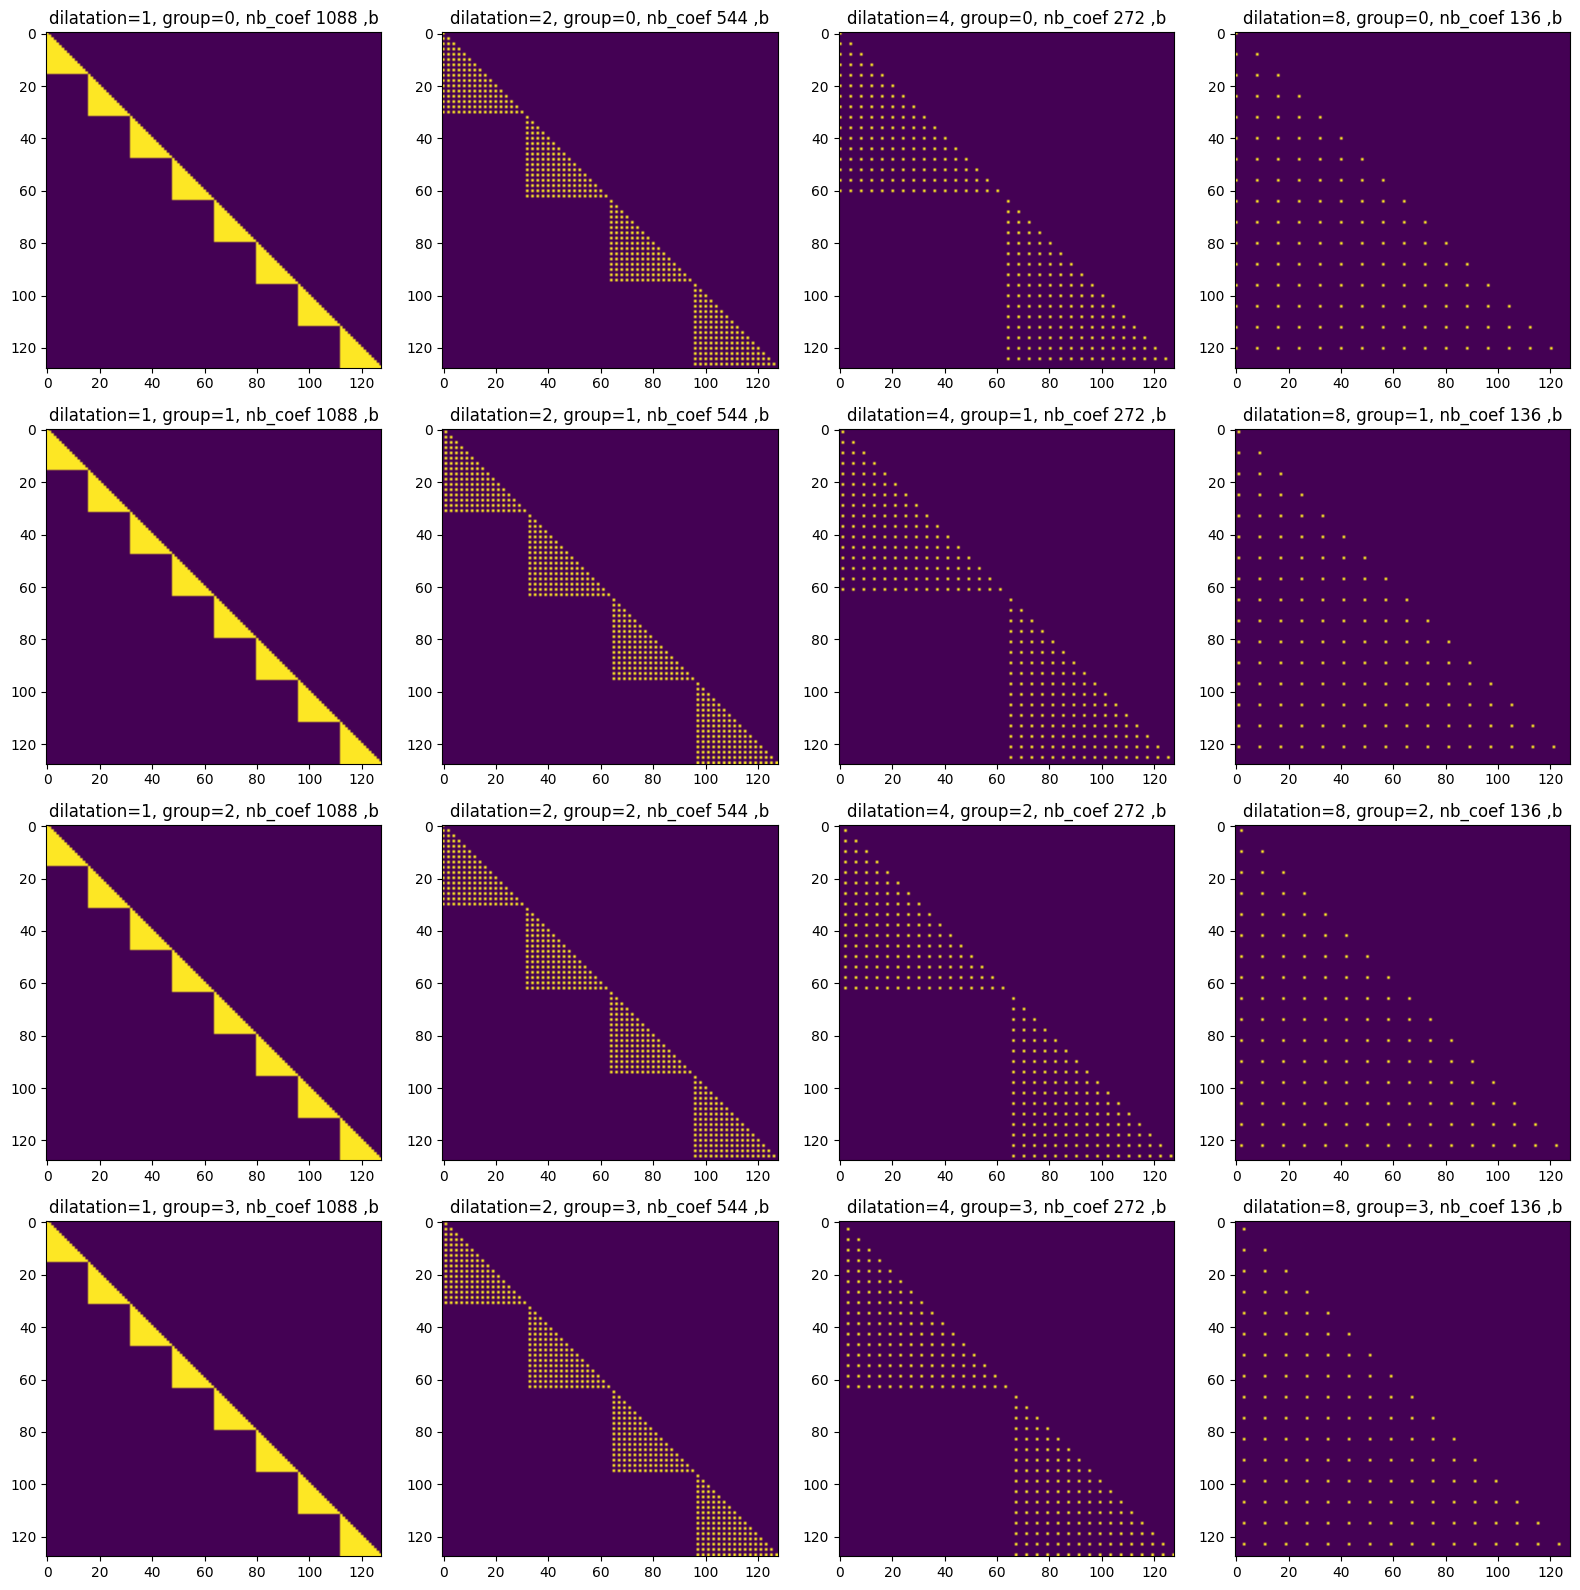

Total coef: 8160


In [84]:
def visualize_attention_patterns(att_agg, binary_mask=False):
    G = att_agg[0].shape[4]
    num_rows = G  # Number of rows in the plot, one for each G
    num_cols = len(att_agg)  # Number of columns in the plot, one for each i

    # Create a figure with subplots
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    total_coefs = 0
    for i in range(len(att_agg)):
        B, T_, S, _, G = att_agg[i].shape
        for g in range(G):
            attn_map_temp = torch.block_diag(*[att_agg[i][0, t, :, :, g] for t in range(T_)])
            r = dilation_rates[i]

            attn_map = torch.zeros((T, T))
            offset = g % r
            attn_map[offset::r, offset::r] = attn_map_temp

            ax = axes[g, i]
            if binary_mask:
                ax.imshow((attn_map > 1e-9).detach().cpu().numpy())
            else:
                ax.imshow((attn_map).detach().cpu().numpy())
            nb_coef = torch.sum(attn_map > 1e-9)
            total_coefs += nb_coef
            ax.set_title(f'dilatation={r}, group={g}, nb_coef {nb_coef}{' ,b' if binary_mask else ''}')

    plt.tight_layout()
    plt.show()
    print(f"Total coef: {total_coefs}")

visualize_attention_patterns(att_agg, binary_mask=True)

## 2. Testing MultiheadDilatedAttention

Now let's test the MultiheadDilatedAttention which combines the dilated attention with multi-head attention.

In [74]:
from model import GPTConfig

B, T, H, D = 1, 128, 16, 32  # batch, seq_len, heads, dim

# Create a config for MultiheadDilatedAttention
config = GPTConfig(
    block_size=16,
    n_head=H,
    n_embd=D,
    dropout=0.0
)


# Initialize the attention module
multihead_attention = MultiheadDilatedAttention(config).to(device)

# Create sample input
x = torch.randn(B,T,D).to(device)  # (batch, seq_len, n_embd)

# Forward pass
output = multihead_attention(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 128, 32])
Output shape: torch.Size([1, 128, 32])


## 3. Comparison with Standard Attention

Let's compare the attention patterns between standard attention and our dilated attention implementation.

In [75]:
class CausalSelfAttention(nn.Module):

    def __init__(self, config):
        super().__init__()
        assert config.n_embd % config.n_head == 0
        # key, query, value projections for all heads, but in a batch
        self.c_attn = nn.Linear(
            config.n_embd, 3 * config.n_embd, bias=config.bias)
        # output projection
        self.c_proj = nn.Linear(config.n_embd, config.n_embd, bias=config.bias)
        # regularization
        self.attn_dropout = nn.Dropout(config.dropout)
        self.resid_dropout = nn.Dropout(config.dropout)
        self.n_head = config.n_head
        self.n_embd = config.n_embd
        self.dropout = config.dropout
        self.register_buffer("bias", torch.tril(torch.ones(config.block_size, config.block_size))
                                 .view(1, 1, config.block_size, config.block_size))

    def forward(self, x):
        B, T, C = x.size()  # batch size, sequence length, embedding dimensionality (n_embd)

        # calculate query, key, values for all heads in batch and move head forward to be the batch dim
        q, k, v = self.c_attn(x).split(self.n_embd, dim=2)
        k = k.view(B, T, self.n_head, C //
                   self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        q = q.view(B, T, self.n_head, C //
                   self.n_head).transpose(1, 2)  # (B, nh, T, hs)
        v = v.view(B, T, self.n_head, C //
                   self.n_head).transpose(1, 2)  # (B, nh, T, hs)

        # causal self-attention; Self-attend: (B, nh, T, hs) x (B, nh, hs, T) -> (B, nh, T, T)
    
        # manual implementation of attention
        att = (q @ k.transpose(-2, -1)) * (1.0 / math.sqrt(k.size(-1)))
        mask = torch.tril(torch.ones_like(att))
        att = att.masked_fill(mask == 0, float('-inf'))
        att = F.softmax(att, dim=-1)
        att = self.attn_dropout(att)
        y = att @ v  # (B, nh, T, T) x (B, nh, T, hs) -> (B, nh, T, hs)
        # re-assemble all head outputs side by side
        y = y.transpose(1, 2).contiguous().view(B, T, C)

        # output projection
        y = self.resid_dropout(self.c_proj(y))
        return y, att

In [76]:
# Initialize the attention module
vanilla_attention = CausalSelfAttention(config).to(device)

# Create sample input
x = torch.randn(B,T,C).to(device)  # (batch, seq_len, n_embd)

# Forward pass
output, att = vanilla_attention(x)

print(f"Input shape: {x.shape}")
print(f"Output shape: {output.shape}")

Input shape: torch.Size([1, 128, 32])
Output shape: torch.Size([1, 128, 32])


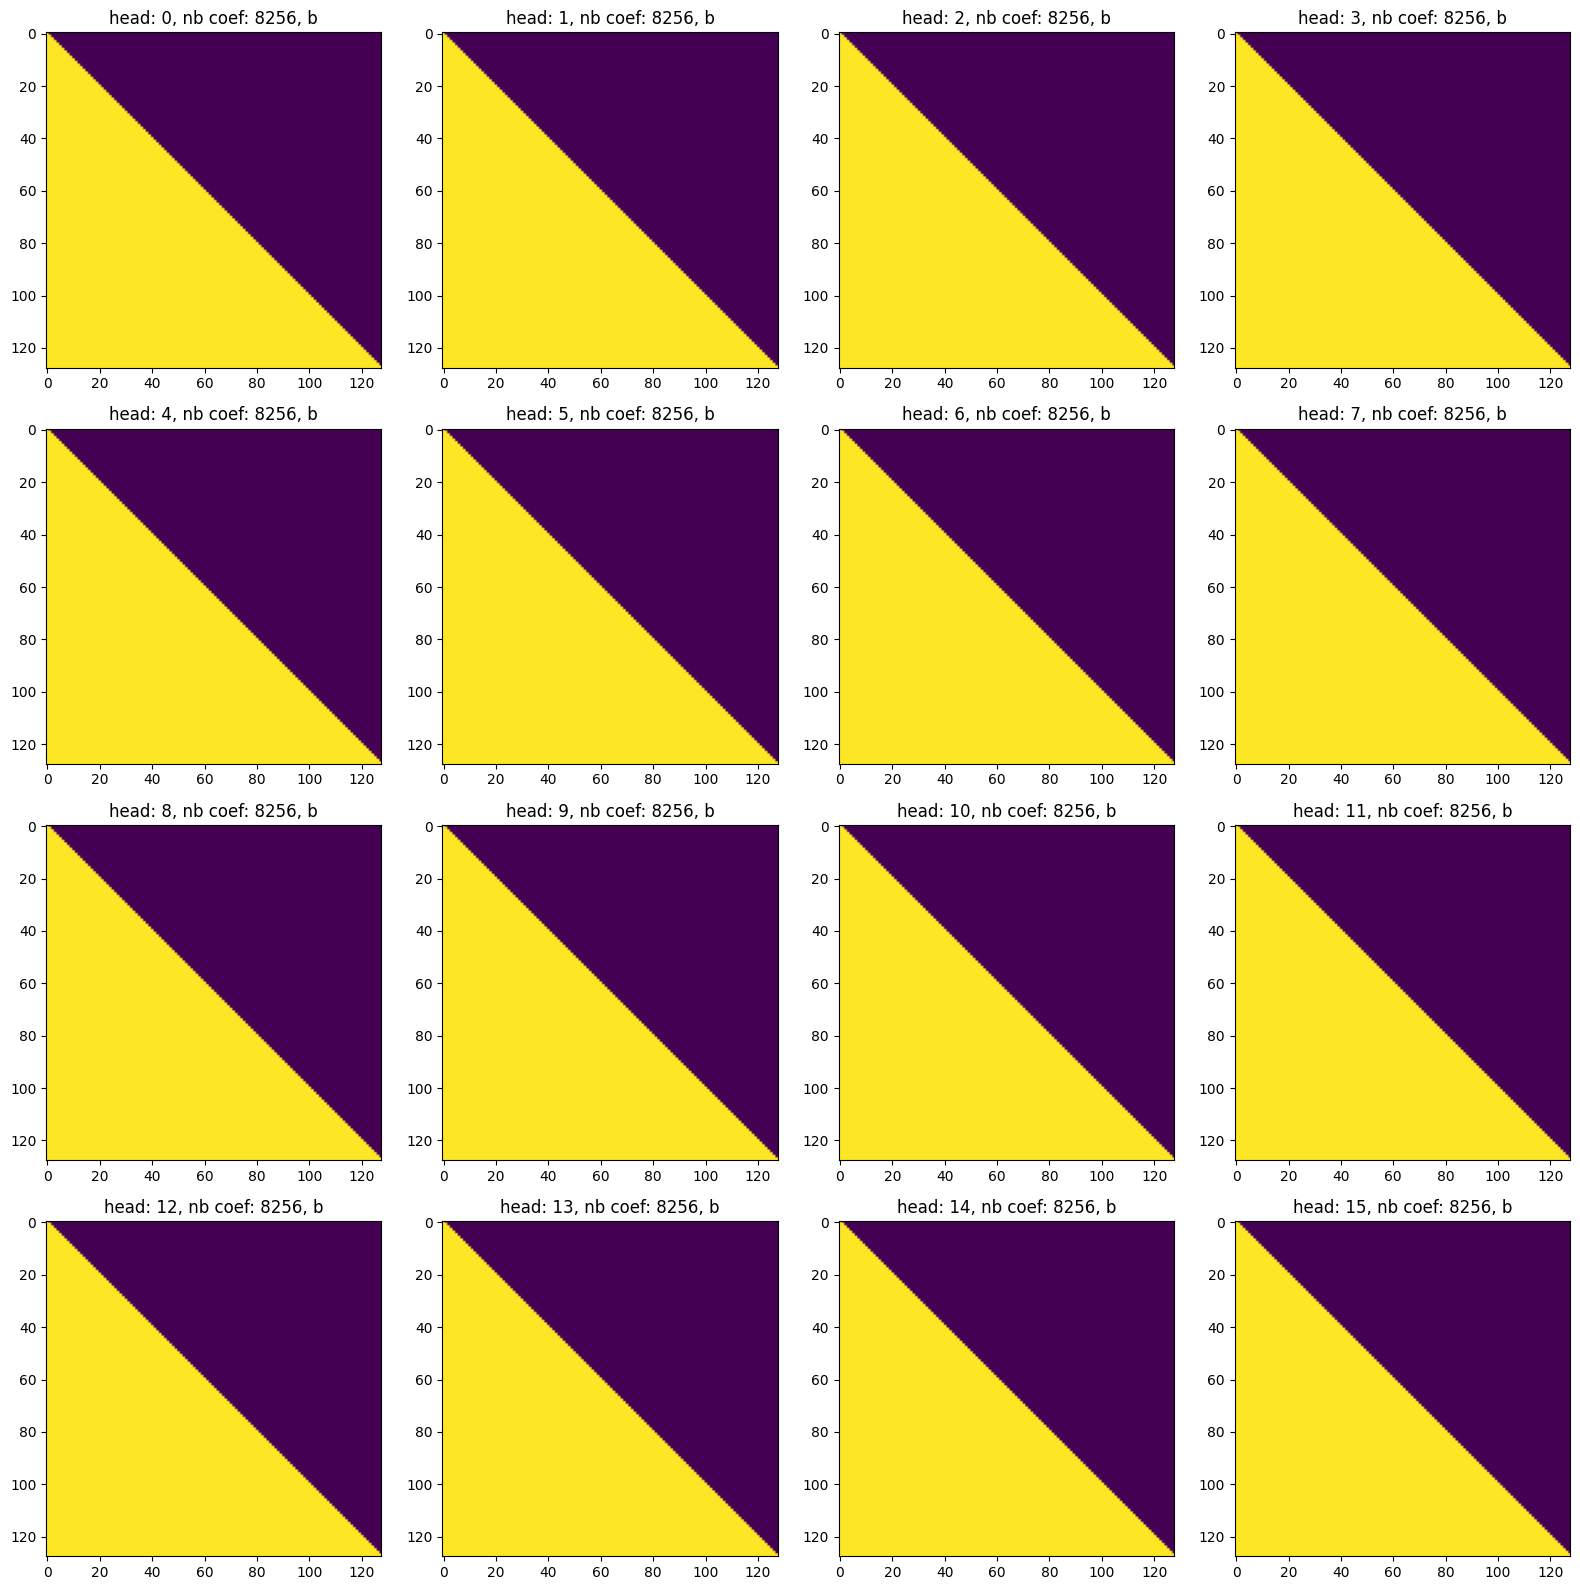

Total coef: 132096


In [82]:
def visualize_vanilla_attention_patterns(att, binary_mask=False, num_cols=4):
    B, H, T, _ = att.shape
    num_rows = H // num_cols
    total_coefs = 0
    fig, axes = plt.subplots(num_rows, num_cols, figsize=(num_cols * 4, num_rows * 4))
    for h in range(H):
        ax = axes[h // 4, h % 4,]
        attn_map = att[0, h, :, :]
        if binary_mask:
            ax.imshow((attn_map > 1e-9).detach().cpu().numpy())
        else:
            ax.imshow((attn_map).detach().cpu().numpy())
        nb_coef = torch.sum(attn_map > 1e-9)
        total_coefs += nb_coef
        ax.set_title(f"head: {h}, nb coef: {nb_coef}, {'b' if binary_mask else''}")
    plt.tight_layout()
    plt.show()
    print(f"Total coef: {total_coefs}")

visualize_vanilla_attention_patterns(att, binary_mask=True)